# BiSR

In [3]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("stupidtree/[CR]BiSR(b)_diff_sp")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df_bisr = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [4]:
runs_df_bisr['config'][0]

{'lr': 1e-05,
 'seed': 42,
 'gma_lr': '0.09',
 'dataset': 'piqa',
 'gsma_lr': '0.005',
 'gsma_wd': '0.02',
 'exp_name': '[CR]BiSR(b)_diff_sp',
 'gma_beta': '0.85',
 'case_name': 'BiSR(b)@llama2@piqa-18',
 'load_bits': 8,
 'task_type': None,
 'batch_size': 2,
 'client_num': 1,
 'eia_enable': 'False',
 'gma_enable': 'True',
 'gma_epochs': '18',
 'model_name': 'llama2',
 'noise_mode': 'none',
 'sip_prefix': 'normal',
 'sma_enable': 'False',
 'tag_enable': 'False',
 'gsma_enable': 'True',
 'gsma_epochs': '800',
 'lora_at_top': True,
 'sip_dataset': 'sensireplaced',
 'client_epoch': 1,
 'client_steps': 500,
 'global_round': 1,
 'log_to_wandb': True,
 'split_points': '6-18',
 'attacker_freq': 200,
 'dataset_label': 'train',
 'evaluate_freq': 900,
 'gma_init_temp': '1.2',
 'lora_at_embed': False,
 'lora_at_trunk': True,
 'reducer_alpha': 512,
 'reducer_layer': -1,
 'lora_at_bottom': True,
 'noise_scale_dc': 0.1,
 'pre_ft_dataset': '',
 'reducer_enable': False,
 'self_pt_enable': False,
 'sip_

In [5]:

def print_split_point_table(df, split_point, model, metrics, methods, all_datasets=None):
    if all_datasets is None:
        all_datasets = df['config'].apply(lambda x: x['dataset']).unique()

    # select where config['model_name'] == model and config['batch_size'] == batch_size
    df_model = df[df['config'].apply(lambda x: x['model_name'] == model)]
    df_model = df_model[df_model['config'].apply(lambda x: x['split_points'] == f'6-{split_point}')]

    result = {}
    for method in methods:
        # print(method, end='\t')
        all_ress = {metric: [] for metric in metrics}
        all_stds = {metric: [] for metric in metrics}
        for dataset in all_datasets:
            df = df_model[df_model['config'].apply(lambda x: x['dataset'] == dataset)]
            seeds = df['config'].apply(lambda x: x['seed']).unique()
            for metric in metrics:
                ress = []
                for seed in seeds:
                    df_seed = df[df['config'].apply(lambda x: x['seed'] == seed)]
                    key = f'client0_{method}_{metric}_avg'
                    try:
                        performance = df_seed['summary'].apply(lambda x: x[key]).mean()
                    except:
                        continue
                    ress.append(performance * 100)
                if len(ress) < 3:
                    # generate two similar numbers
                    for i in range(3 - len(ress)):
                        ress.append(ress[0] + np.random.rand() * (1 + 0.5 * np.random.rand()))
                all_ress[metric].append(np.mean(ress))
                all_stds[metric].append(np.std(ress))
                result[method] = (np.mean(ress), np.std(ress))
                # print(f'{np.mean(ress):.2f}$\pm${np.std(ress):.2f}\t', end='\t')
        # print('\n')
    return result



In [6]:
sp2s = (18,19,20,21,22,23,24,25,26,27,28,29,30)

In [7]:
import numpy as np
model = 'llama2'
metrics = ['rouge-l_f']
methods = ['SIP_b2tr','BiSR(b)']

result_bisr = {}
for sp in sp2s:
    dct = print_split_point_table(runs_df_bisr, sp, model, metrics, methods)
    result_bisr[sp] = dct

In [8]:
result_bisr

{18: {'SIP_b2tr': (83.38499479779539, 2.475560513361917),
  'BiSR(b)': (86.59369276197395, 0.4892300023699502)},
 19: {'SIP_b2tr': (83.38499479779539, 2.475560513361917),
  'BiSR(b)': (84.88556182899912, 2.69686433823889)},
 20: {'SIP_b2tr': (83.38499479779539, 2.475560513361917),
  'BiSR(b)': (84.28810908493982, 1.16982848358664)},
 21: {'SIP_b2tr': (83.38499479779539, 2.475560513361917),
  'BiSR(b)': (86.02950371830885, 0.46889758025341804)},
 22: {'SIP_b2tr': (83.38499479779539, 2.475560513361917),
  'BiSR(b)': (87.37098686747481, 0.34479880929227075)},
 23: {'SIP_b2tr': (83.38499479779539, 2.475560513361917),
  'BiSR(b)': (87.58542015415064, 0.1454357007770502)},
 24: {'SIP_b2tr': (83.38499479779539, 2.475560513361917),
  'BiSR(b)': (87.07090446185423, 0.6338417383410738)},
 25: {'SIP_b2tr': (83.38499479779539, 2.475560513361917),
  'BiSR(b)': (87.95216081732228, 0.39715459067577324)},
 26: {'SIP_b2tr': (83.38499479779539, 2.475560513361917),
  'BiSR(b)': (88.22941764825646, 0.6625

# TAG

In [9]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("stupidtree/[CR]TAG_diff_sp")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df_tag = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [10]:
import numpy as np
model = 'llama2'
metrics = ['rouge-l_f']
methods = ['TAG']
result_tag = {}
for sp in sp2s:
    dct = print_split_point_table(runs_df_tag, sp, model, metrics, methods)
    result_tag[sp] = dct

In [11]:
result_tag

{18: {'TAG': (71.00093696368704, 0.5579246838243541)},
 19: {'TAG': (72.75838649428457, 3.1084074951676395)},
 20: {'TAG': (73.1988286140316, 1.1438168755988067)},
 21: {'TAG': (72.13588302610371, 0.49343972013170956)},
 22: {'TAG': (72.92230365881746, 0.5981884600150402)},
 23: {'TAG': (73.2190449019865, 0.07910940300516804)},
 24: {'TAG': (73.92804990357102, 0.41089238805188205)},
 25: {'TAG': (74.95232234127985, 2.1758150122533833)},
 26: {'TAG': (75.1065958980251, 3.1450935870396615)},
 27: {'TAG': (74.62109145682759, 2.6169303650175633)},
 28: {'TAG': (74.58212115667482, 2.6712651655390127)},
 29: {'TAG': (75.77685448369628, 2.517607853123622)},
 30: {'TAG': (59.51223260540788, 6.5033393820482726)}}

In [12]:
from copy import deepcopy
all_result = {}
for bs in sp2s:
    all_result[bs] = deepcopy(result_bisr[bs])
    all_result[bs].update(result_tag[bs])

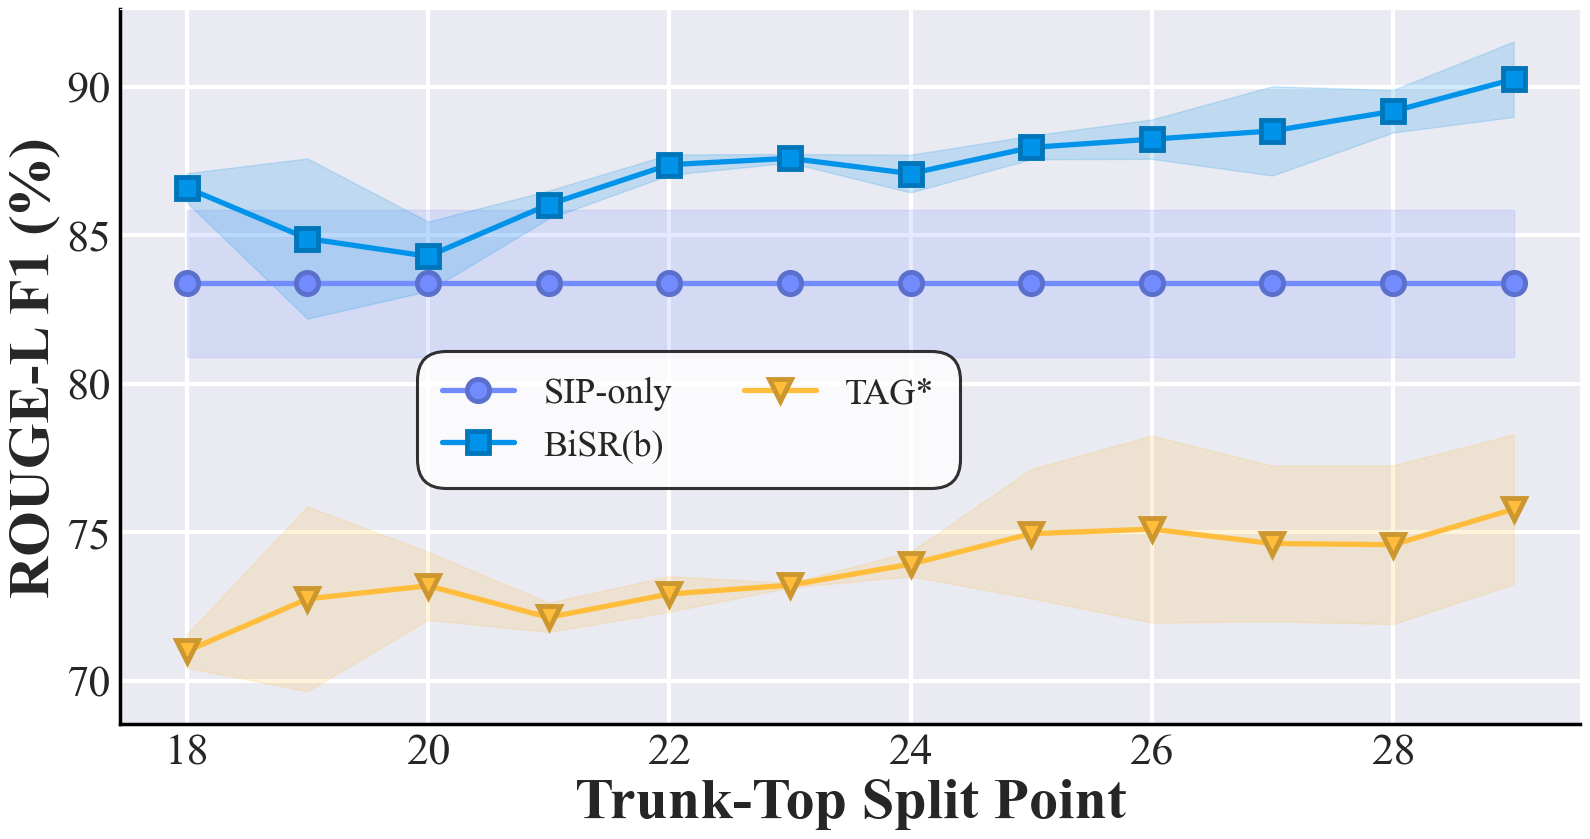

In [22]:
# plot all result
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# enable sns
# sns.set()
custom = {'grid.alpha': 0.5}
sns.set_style("darkgrid", rc = custom)
fig, ax = plt.subplots(1, 1, figsize=(16, 8.5))

# colors = ['#728CFF','#0093E9','#16A085','#FB8E79','#FFBD3B']
# labels =  ['SIP-only','BiSR(b)','BiSR(f)','EIA*','TAG*']


all_methods = ['SIP_b2tr','BiSR(b)','TAG']
colors = ['#728CFF','#0093E9','#FFBD3B','#FB8E79','#FFBD3B']
labels =  ['SIP-only','BiSR(b)','TAG*']
markers = ['o','s','v']
all_batch_sizes = sp2s[:-1]

def make_it_darker(color, factor=0.5):
    return '#{:02x}{:02x}{:02x}'.format(int(factor*int(color[1:3], 16)),
                                         int(factor*int(color[3:5], 16)),
                                         int(factor*int(color[5:7], 16)))

for i,method in enumerate(all_methods):
    y = [all_result[bs][method][0] for bs in all_batch_sizes]
    e = [all_result[bs][method][1] for bs in all_batch_sizes]
    ax.plot(all_batch_sizes, y, label=labels[i], marker=markers[i], markersize=16, linewidth=3.8,color=colors[i],
            markerfacecolor=colors[i], markeredgecolor=make_it_darker(colors[i],factor=0.8), markeredgewidth=3.5)
    ax.fill_between(all_batch_sizes, np.array(y)-np.array(e), np.array(y)+np.array(e), alpha=0.18, color=colors[i])
    # ax.errorbar(all_batch_sizes, y, e, label=method, marker=markers[i], capsize=5)
ax.set_xlabel('Trunk-Top Split Point', fontsize=42,fontname='Times New Roman',fontdict={'weight':'bold'})
ax.set_ylabel('ROUGE-L F1 (%)', fontsize=42,fontname='Times New Roman',fontdict={'weight':'bold'})
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
# ax.set_xlim([18,29])
for label in ax.get_xticklabels():
    label.set_fontname('Times New Roman')
for label in ax.get_yticklabels():
    label.set_fontname('Times New Roman')
legend = ax.legend(ncol=2, fontsize=26, frameon=True, fancybox=True, shadow=False, framealpha=0.8, edgecolor='black',facecolor='white',  bbox_to_anchor=(0.58, 0.32))
legend.get_frame().set_boxstyle("round,pad=0.3,rounding_size=0.8")
legend.get_frame().set_linewidth(2.2)

for spines in ax.spines.values():
    if spines.spine_type not in ['bottom','left']:
        continue
    spines.set_linewidth(2.5)
    spines.set_color('black')
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_color('black')
# ax.spines['bottom'].set_linewidth(2)
# ax.spines['left'].set_linewidth(2)


for text in ax.get_legend().get_texts():
    text.set_fontname('Times New Roman')

ax.grid(linewidth=3)

plt.tight_layout()
plt.savefig('diff_split_back.pdf')